## Preparing the Data

In [the previous tutorial](https://jovian.ai/aakashns/03-logistic-regression), we trained a logistic regression model to identify handwritten digits from the MNIST dataset with an accuracy of around 85%. The dataset consists of 28px by 28px grayscale images of handwritten digits (0 to 9) and labels for each image indicating which digit it represents. Here are some sample images from the dataset:

![mnist-sample](https://i.imgur.com/CAYnuo1.jpg)

We noticed that it's quite challenging to improve the accuracy of a logistic regression model beyond 87%, since the model assumes a linear relationship between pixel intensities and image labels. In this post, we'll try to improve upon it  using a *feed-forward neural network* which can capture non-linear relationships between inputs and targets.

Let's begin by installing and importing the required modules and classes from `torch`, `torchvision`, `numpy`, and `matplotlib`.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F # For the activation functions
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt

We can download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`. 

In [2]:
dataset = MNIST(root='/Datasets', download=True, transform=ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /Datasets/MNIST/raw/train-images-idx3-ubyte.gz to /Datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /Datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /Datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /Datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Datasets/MNIST/raw



Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

Image Shape:  torch.Size([1, 28, 28])
Label: 5


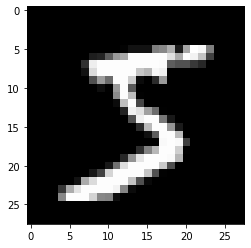

In [3]:
image, label = dataset[0]
print('Image Shape: ', image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print('Label:', label)

Image Shape:  torch.Size([1, 28, 28])
Label: 4


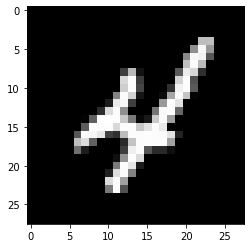

In [4]:
image, label = dataset[9]
print('Image Shape: ', image.shape)
plt.imshow(image.permute(1,2,0), cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [5]:
valid_size = 10_000
train_size = len(dataset) - valid_size

train_ds, valid_ds = random_split(dataset, [train_size, valid_size])
print(len(train_ds), len(valid_ds))

50000 10000


We can now create PyTorch data loaders for training and validation.

In [6]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=2, pin_memory=True)

Can you figure out the purpose of the arguments `num_workers` and `pin_memory`? Try looking into the documentation: https://pytorch.org/docs/stable/data.html.

* num_workers (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)
* pin_memory (bool, optional) – If True, the data loader will copy Tensors into CUDA pinned memory before returning them. If your data elements are a custom type, or your collate_fn returns a batch that is a custom type, see the example below.

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

Images Shape: torch.Size([128, 1, 28, 28])


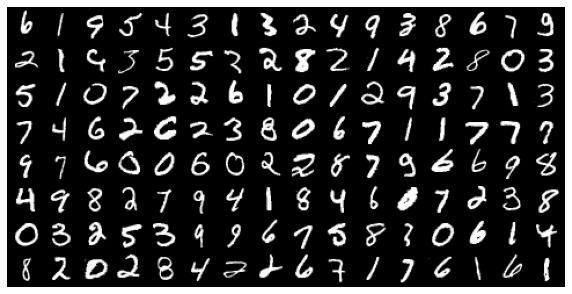

In [7]:
for images, _ in train_dl:
    print("Images Shape:", images.shape)
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a _hidden layer_ and an _output layer_. Additionally, we'll use an _activation function_ between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture non-linear relationships between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [8]:
for images, labels in train_dl:
    print("Image shape: ", images.shape)
    inputs = images.reshape(-1, 28*28)
    print("Image shape: ", inputs.shape)
    break

Image shape:  torch.Size([128, 1, 28, 28])
Image shape:  torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our _hidden_ layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the _learning capacity_ of the model.

In [9]:
input_size = inputs.shape[-1]
hidden_size = 32

layer_1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

In [10]:
layer_1_outputs = layer_1(inputs)
print("layer_1 output shape: ", layer_1_outputs.shape)

layer_1 output shape:  torch.Size([128, 32])


The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with the transposed weights matrix of `layer1` and adding the bias. We can verify this using `torch.allclose`. For a more detailed explanation, review the tutorial on [linear regression](https://jovian.ai/aakashns/02-linear-regression).

In [11]:
layer_1_outputs_direct = inputs @ layer_1.weight.t() + layer_1.bias
print(layer_1_outputs_direct.shape)

torch.Size([128, 32])


In [12]:
print(torch.allclose(layer_1_outputs_direct, layer_1_outputs))

True


Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture linear relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">


Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [13]:
print(F.relu(torch.tensor([-1, 2, -3, 9])))

tensor([0, 2, 0, 9])


Let's apply the activation function to `layer1_outputs` and verify that negative values were replaced with 0.

In [14]:
relu_outputs = F.relu(layer_1_outputs)
print("min(layer_1_direct_outputs)", torch.min(layer_1_outputs_direct).item())
print("min(layer_1_outputs)", torch.min(relu_outputs).item())

min(layer_1_direct_outputs) -0.8941729664802551
min(layer_1_outputs) 0.0


Now that we've applied a non-linear activation function, `relu_outputs` and `inputs` do not have a linear relationship. We refer to `ReLU` as the _activation function_, because for each input certain outputs are activated (those with non-zero values) while others turned off (those with zero values)

Next, let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

In [15]:
output_size = 10
layer_2 = nn.Linear(hidden_size, output_size)

layer_2_outputs = layer_2(relu_outputs)
print(layer_2_outputs.shape)

torch.Size([128, 10])


As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [16]:
print(F.cross_entropy(layer_2_outputs, labels))

tensor(2.3095, grad_fn=<NllLossBackward0>)


Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`), followed by a non-linear activation (using `F.relu`), followed by another linear transformation (using `layer2`). Let's verify this by re-computing the output using basic matrix operations.

In [17]:
outputs = F.relu((inputs @ layer_1.weight.t() + layer_1.bias)) @ layer_2.weight.t() + layer_2.bias
print(outputs.shape)

torch.Size([128, 10])


In [18]:
print(torch.allclose(outputs, layer_2_outputs))

True


Note that `outputs` and `inputs` do not have a linear relationship due to the non-linear activation function `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationships between the images and their labels. In other words, introducing non-linearity makes the model more powerful and versatile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can also introduce new hidden layers and apply the same non-linear activation after each hidden layer.

The model we just created is called a neural network. A _deep neural network_ is simply a neural network with one or more hidden layers. In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it can _learn_ rich and complex non-linear relationships between inputs and targets. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results. Deep learning models often contain millions of parameters, which can together capture far more complex relationships than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network. 

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

In [112]:
def accuracy(model_out, labels):
    _, preds = torch.max(model_out, dim=1)
    return torch.sum(preds == labels) / labels.numel()

Let's define the model by extending the `nn.Module` class from PyTorch.

In [113]:
class MNIST_model(nn.Module):
    def __init__(self, in_size, hid_size, out_size):
        super().__init__()
        # hidden layer
        self.linear_1 = nn.Linear(in_size, hid_size)
        # output layer
        self.linear_2 = nn.Linear(hid_size, out_size)
        
    def __call__(self, input_batch):
        # Cutting the channel dimension
        input_batch = input_batch.view(input_batch.size(0), -1)
        # Feed the batch into the hidden layer
        out = self.linear_1(input_batch).to(device)
        # Apply non linearity
        out = F.relu(out).to(device)
        # Feed the non linear data into the output layer
        out = self.linear_2(out).to(device)
        return out
    
    def training_step(self, batch):
        # Unpacking the batch elements
        input_batch, output_batch = batch
        # Getting the predictions
        out = self(input_batch)
        # Calculate loss
        loss = F.cross_entropy(out, output_batch)
        return loss
    
    def validation_step(self, batch):
        # Unpacking the batch elements
        input_batch, output_batch = batch
        # Generating predictions
        out = self(input_batch)
        # Calculate loss and accuracy
        loss = F.cross_entropy(out, output_batch)
        acc = accuracy(out, output_batch)
        return {"valid_batch_loss": loss.item(), "valid_batch_acc": acc.item()}
    
    def validation_end(self, results):
        # Computing the average loss and accuracy of the validation batch
        avg_loss = torch.tensor([x["valid_batch_loss"] for x in results]).mean()
        avg_acc = torch.tensor([x["valid_batch_acc"] for x in results]).mean()
        return {"valid_loss": avg_loss.item(), "valid_acc": avg_acc.item()}
    
    def epoch_end(self, epoch, results):
        # Return the results
        return {"Epoch": epoch, "Loss": results["valid_loss"], "Acc": results["valid_acc"]}
    

model = MNIST_model(input_size, hidden_size, output_size)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [114]:
for w in model.parameters():
    print(w.shape)
    print(w.device)

torch.Size([32, 784])
cpu
torch.Size([32])
cpu
torch.Size([10, 32])
cpu
torch.Size([10])
cpu


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain hundreds of cores optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [115]:
print(torch.cuda.is_available())

True


Let's define a helper function to ensure that our code uses the GPU if available and defaults to using the CPU if it isn't. 

In [116]:
def default_device():
    # Selecting GPU if is available else CPU
    if torch.cuda.is_available():
        return torch.device("cuda")
    
    return torch.device("cpu")

In [117]:
device = default_device()
print(device)

cuda


Next, let's define a function that can move data and model to a chosen device.

In [118]:
def to_device(device, data):
    if isinstance(data, (list, tuple)):
        return [to_device(device, x) for x in data]
    
    return data.to(device, non_blocking=True) # For pin memory

In [119]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(device, images)
    print(images.shape)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
cuda:0


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move batches of data to the selected device. Interestingly, we don't need to extend an existing class to create a PyTorch datal oader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

In [120]:
class DeviceDataLoader:
    def __init__(self, loader, device):
        # Class atributs
        self.loader = loader
        self.device = device
        
    def __iter__(self):
        # Tranfering each batch to device one by one, with yield, iteration after iteration.
        for batch in self.loader:
            yield to_device(self.device, batch)
            
    def __len__(self):
        # Getting the number of batches
        return len(self.loader)

We can now wrap our data loaders using `DeviceDataLoader`.

In [121]:
train_loader = DeviceDataLoader(train_dl, device)
valid_loader = DeviceDataLoader(valid_dl, device)

Tensors moved to the GPU have a `device` property which includes that word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`.

In [122]:
for batch_input, batch_output in train_loader:
    print(batch_output.device)
    print(batch_output)
    break
    
for batch in train_loader:
    print(batch[0].device)
    break

cuda:0
tensor([3, 3, 4, 0, 2, 3, 0, 7, 0, 0, 6, 6, 4, 5, 1, 1, 2, 6, 4, 4, 1, 1, 4, 4,
        5, 0, 6, 5, 9, 2, 4, 1, 8, 7, 3, 4, 2, 0, 8, 1, 9, 7, 9, 3, 9, 3, 9, 2,
        5, 3, 2, 9, 7, 4, 9, 7, 3, 4, 8, 0, 0, 3, 6, 7, 6, 9, 6, 4, 1, 9, 8, 5,
        2, 6, 7, 4, 2, 8, 0, 0, 0, 5, 7, 5, 1, 0, 5, 1, 6, 6, 5, 5, 5, 7, 7, 6,
        2, 9, 2, 5, 2, 7, 3, 8, 5, 4, 7, 3, 5, 5, 9, 6, 8, 6, 5, 0, 4, 3, 2, 7,
        8, 0, 2, 9, 6, 6, 6, 3], device='cuda:0')
cuda:0


## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [123]:
def evaluate(model, val_loader):
    # Evaluating the model base on the validation data loader (calculating loss and acc)
    results = [model.validation_step(batch) for batch in val_loader]
    return model.validation_end(results)

In [124]:
def fit(model, epochs, lr, trian_loader, valid_loader, opt_fn=torch.optim.SGD):
    history = []
    opt = opt_fn(model.parameters(), lr)
    for epoch in range(epochs):
        for batch in trian_loader:
            loss = model.training_step(batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        results = evaluate(model, valid_loader)
        epoch_results = model.epoch_end(epoch+1, results)
        history.append(epoch_results)
        
        print({"Epoch": epoch+1, "Loss": epoch_results["Loss"], "Acc": epoch_results["Acc"]})
        
    return history

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device. 

In [125]:
print(model.to(device))

for w in model.parameters():
    print(w.shape)
    print(w.device)

MNIST_model(
  (linear_1): Linear(in_features=784, out_features=32, bias=True)
  (linear_2): Linear(in_features=32, out_features=10, bias=True)
)
torch.Size([32, 784])
cuda:0
torch.Size([32])
cuda:0
torch.Size([10, 32])
cuda:0
torch.Size([10])
cuda:0


Let's see how the model performs on the validation set with the initial set of weights and biases.

In [126]:
history = evaluate(model, valid_loader)
print(history)

{'valid_loss': 2.312669277191162, 'valid_acc': 0.10605468600988388}


In [127]:
history1 = fit(model, 5, 0.5, train_loader, valid_loader)

{'Epoch': 1, 'Loss': 0.23149247467517853, 'Acc': 0.931640625}
{'Epoch': 2, 'Loss': 0.178511381149292, 'Acc': 0.944531261920929}
{'Epoch': 3, 'Loss': 0.15071341395378113, 'Acc': 0.953320324420929}
{'Epoch': 4, 'Loss': 0.14981164038181305, 'Acc': 0.9581054449081421}
{'Epoch': 5, 'Loss': 0.15704019367694855, 'Acc': 0.9541015625}


In [128]:
history2 = fit(model, 5, 0.1, train_loader, valid_loader)

{'Epoch': 1, 'Loss': 0.11592230945825577, 'Acc': 0.965624988079071}
{'Epoch': 2, 'Loss': 0.11440898478031158, 'Acc': 0.966601550579071}
{'Epoch': 3, 'Loss': 0.1162281185388565, 'Acc': 0.9647461175918579}
{'Epoch': 4, 'Loss': 0.11342022567987442, 'Acc': 0.9673827886581421}
{'Epoch': 5, 'Loss': 0.11404174566268921, 'Acc': 0.965527355670929}


In [129]:
history3 = fit(model, 5, 0.05, train_loader, valid_loader)

{'Epoch': 1, 'Loss': 0.11088816821575165, 'Acc': 0.9673827886581421}
{'Epoch': 2, 'Loss': 0.11121080815792084, 'Acc': 0.966796875}
{'Epoch': 3, 'Loss': 0.11049813032150269, 'Acc': 0.9676758050918579}
{'Epoch': 4, 'Loss': 0.10961411893367767, 'Acc': 0.9671875238418579}
{'Epoch': 5, 'Loss': 0.1098627895116806, 'Acc': 0.96728515625}


In [130]:
h = history1 + history2 + history3

In [131]:
print(h)

[{'Epoch': 1, 'Loss': 0.23149247467517853, 'Acc': 0.931640625}, {'Epoch': 2, 'Loss': 0.178511381149292, 'Acc': 0.944531261920929}, {'Epoch': 3, 'Loss': 0.15071341395378113, 'Acc': 0.953320324420929}, {'Epoch': 4, 'Loss': 0.14981164038181305, 'Acc': 0.9581054449081421}, {'Epoch': 5, 'Loss': 0.15704019367694855, 'Acc': 0.9541015625}, {'Epoch': 1, 'Loss': 0.11592230945825577, 'Acc': 0.965624988079071}, {'Epoch': 2, 'Loss': 0.11440898478031158, 'Acc': 0.966601550579071}, {'Epoch': 3, 'Loss': 0.1162281185388565, 'Acc': 0.9647461175918579}, {'Epoch': 4, 'Loss': 0.11342022567987442, 'Acc': 0.9673827886581421}, {'Epoch': 5, 'Loss': 0.11404174566268921, 'Acc': 0.965527355670929}, {'Epoch': 1, 'Loss': 0.11088816821575165, 'Acc': 0.9673827886581421}, {'Epoch': 2, 'Loss': 0.11121080815792084, 'Acc': 0.966796875}, {'Epoch': 3, 'Loss': 0.11049813032150269, 'Acc': 0.9676758050918579}, {'Epoch': 4, 'Loss': 0.10961411893367767, 'Acc': 0.9671875238418579}, {'Epoch': 5, 'Loss': 0.1098627895116806, 'Acc':

We can now plot the losses & accuracies to study how the model improves over time.

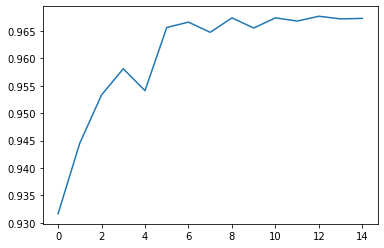

In [132]:
accuracies = [x["Acc"] for x in h]
plt.plot(accuracies)
plt.show()

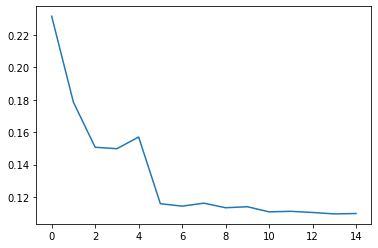

In [133]:
accuracies = [x["Loss"] for x in h]
plt.plot(accuracies)
plt.show()

Our current model outperforms the logistic regression model (which could only achieve around 86% accuracy) by a considerable margin! It quickly reaches an accuracy of 97% but doesn't improve much beyond this. To improve accuracy further, we need to make the model more powerful by increasing the hidden layer's size or adding more hidden layers with activations. I encourage you to try out both these approaches and see which one works better.

## Testing with individual images

While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the predefined test dataset of 10000 images. We begin by recreating the test dataset with the `ToTensor` transform.

In [134]:
test_ds = MNIST(root='/Datasets', train=False, transform=ToTensor())

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [135]:
def predict_image(image, model):
    image = to_device(device, image.unsqueeze(0))
    output = model(image)
    _, pred = torch.max(output, dim=1)
    return pred.item()

Label:  1 Predicted:  1


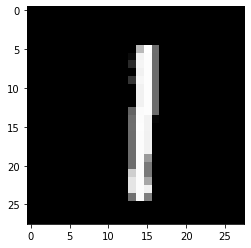

In [136]:
img, label = test_ds[180]
pred = predict_image(img, model)
print("Label: ", label, "Predicted: ", pred)
plt.imshow(img[0], cmap="gray")
plt.show()